## Train a semantic segmentation unet using Pytorch

## Pytorch setup

setting up environment (Windows 10 with Cuda 11.8)

```
conda create --name pytorch_tests python=3.10
conda activate pytorch_tests
conda install pip
pip install pykernel
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install pytorch-lightning
pip install monai
pip install scipy
pip install tifffile
pip install matplotlib
```

## Imports

In [19]:
from tifffile import imread
from tqdm import tqdm
from tnia.deeplearning.dl_helper import quantile_normalization
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

## Check if GPU is present

In [20]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set up image and label directories

In [21]:
from pathlib import Path
import json

tnia_images_path = Path("D:/images/tnia-python-images")
parent_path=Path(tnia_images_path / r'imagesc/2024_05_03_mouse_and_grid')

name = '6AMAH2b-left'
ext = '.png'
train_path= parent_path / 'patches' 

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data.get('sub_sample',1)
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = train_path / 'ground truth0'
label_patch_path = train_path / 'input0'


sub_sample 1
axes YXC


## Create a PyTorch Dataset

Dataset is simply used to retrieve the training patches.  In this case we just set it up to read in image files, then convert the numpy arrays to tensors and a torch stack.

In this example augmentation was done in a previous notebook, and the augmented images explicitly saved.  It is also possible to do augmentation as the data is retrieved.  So in the future the ```MyDataSet``` could be extended to apply augmentation as data is retrieved.

In [22]:
class MyDataSet():

    def __init__(self, image_files, label_files, target_shape=(256, 256, 3)):
            """
            Parameters
            ----------
            image_files: list of pathlib.Path objects pointing to the *.tif images
            label_files: list of pathlib.Path objects pointing to the *.tif segmentation masks
            target_shape: tuple of length 2 specifying the sample resolutions of files that
                        will be kept. All other files will NOT be used.
            """
            assert len(image_files) == len(label_files)
            assert all(x.name==y.name for x,y in zip(image_files, label_files))

            self.images = []
            self.labels = []

            tensor_transform = transforms.Compose([
                v2.ToTensor(),
            ])

            # use tqdm to have eye pleasing error bars
            for idx in tqdm(range(len(image_files))):
                # we use the same data reading approach as in the previous notebook
                image = imread(image_files[idx])
                label = imread(label_files[idx])

                if image.shape != target_shape:
                    continue
                
                # do the normalizations
                #image = quantile_normalization(
                #   image,
                #    quantile_low=0.01,
                #    quantile_high=0.998,
                #    clip=True)[0].astype(np.float32)

                # NOTE: we convert the label to dtype float32 and not uint8 because
                # the tensor transformation does a normalization if the input is of
                # dtype uint8, destroying the 0/1 labelling which we want to avoid.
                #label = fill_label_holes(label)
                label_binary = np.zeros_like(label).astype(np.float32)
                label_binary[label != 0] = 1.
                

                # convert to torch tensor: adds an artificial color channel in the front
                # and scales inputs to have same size as samples tend to differ in image
                # resolutions
                image = tensor_transform(image)
                label = tensor_transform(label_binary)

                self.images.append(image)
                self.labels.append(label)

            self.images = torch.stack(self.images)
            self.labels = torch.stack(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

## Initialize the DataSet 

Initialize the DataSet with the pre-generated patch names

In [23]:
src_dir = train_path

assert src_dir.exists(), f"root directory with images and masks {src_dir} does not exist"

X = sorted(src_dir.rglob('**/input0/*.tif'))
Y = sorted(src_dir.rglob('**/ground truth0/*.tif'))

train_data = MyDataSet(
    image_files=X,
    label_files=Y,
    target_shape=(256, 256, 3)
)

# NOTE: the length of the dataset might not be the same as n_samples
#       because files not having the target shape will be discarded
print(len(train_data))


c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 405/405 [00:01<00:00, 206.79it/s]

405


## Create a DataLoader

This is done so we can load batches of images. 

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Create a UNET

In [8]:
from monai.networks.nets import BasicUNet

model = BasicUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    #features=[16, 16, 32, 64, 128, 16],
    act="relu",
    norm="batch",
    dropout=0.25,
)

# Important: transfer the model to the chosen device
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
init_params = list(model.parameters())[0].clone().detach()

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Train the UNET

In [25]:
max_nepochs = 200
log_interval = 20
model.train(True)

# BCEWithLogitsLoss combines sigmoid + BCELoss for better
# numerical stability. It expects raw unnormalized scores as input which are shaped like 
# B x C x W x D
loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in range(1, max_nepochs + 1):
    for batch_idx, (X, y) in enumerate(train_loader):
        # the inputs and labels have to be on the same device as the model
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()

        prediction_logits = model(X)
        
        batch_loss = loss_function(prediction_logits, y)

        batch_loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch:",
                epoch,
                "Batch:",
                batch_idx,
                "Total samples processed:",
                (batch_idx + 1) * train_loader.batch_size,
                "Loss:",
                batch_loss.item(),
            )

Train Epoch: 1 Batch: 0 Total samples processed: 32 Loss: 0.12215735018253326
Train Epoch: 2 Batch: 0 Total samples processed: 32 Loss: 0.12855733931064606
Train Epoch: 3 Batch: 0 Total samples processed: 32 Loss: 0.11638075858354568
Train Epoch: 4 Batch: 0 Total samples processed: 32 Loss: 0.1331566870212555
Train Epoch: 5 Batch: 0 Total samples processed: 32 Loss: 0.1317085474729538
Train Epoch: 6 Batch: 0 Total samples processed: 32 Loss: 0.11527685821056366
Train Epoch: 7 Batch: 0 Total samples processed: 32 Loss: 0.12198638916015625
Train Epoch: 8 Batch: 0 Total samples processed: 32 Loss: 0.11997555941343307
Train Epoch: 9 Batch: 0 Total samples processed: 32 Loss: 0.1124449223279953
Train Epoch: 10 Batch: 0 Total samples processed: 32 Loss: 0.11720298230648041
Train Epoch: 11 Batch: 0 Total samples processed: 32 Loss: 0.1078234314918518
Train Epoch: 12 Batch: 0 Total samples processed: 32 Loss: 0.11213716864585876
Train Epoch: 13 Batch: 0 Total samples processed: 32 Loss: 0.1113

## Look at self-prediction

Self-prediction does not tell us how the UNET will perform on new data, but it is a useful check to make sure the UNET is learning the training data. 

In [26]:
len(X)
X.shape

torch.Size([21, 3, 256, 256])

Text(0.5, 1.0, 'Predictions')

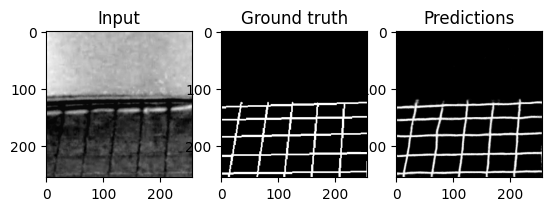

In [27]:
import matplotlib.pyplot as plt

# convert to 0/1 range on each pixel
prediction = torch.nn.functional.sigmoid(prediction_logits)
prediction_binary = prediction #(prediction > 0.5).to(torch.uint8)

sidx = 1
plt.subplot(131)
plt.imshow(X[sidx, 0].cpu().numpy(), cmap="gray")
plt.title("Input")

plt.subplot(132)
plt.imshow(y[sidx, 0].cpu().numpy(), cmap="gray")
plt.title("Ground truth")

plt.subplot(133)
plt.imshow(prediction_binary.cpu().detach()[sidx, 0].numpy(), cmap="gray")
plt.title("Predictions")

## Save the UNET

In [28]:
torch.save(model.state_dict(), train_path / 'model1')

## Test on unseen data

original min max 3 255


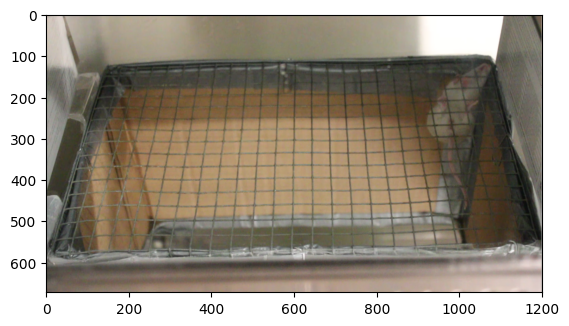

In [34]:
from skimage.io import imread as skimread
test_name = r'6AMAH2b.png'
testim = skimread(parent_path  / test_name) 
testim.shape
plt.imshow(testim, cmap="gray")
print('original min max', testim.min(), testim.max())

In [35]:
testim_ = testim.copy().astype(np.float32)
for i in range(testim.shape[2]):
    testim_[:,:,i] = quantile_normalization(
        testim[:,:,i],
        quantile_low=0.01,
        quantile_high=0.998,
        clip=True).astype(np.float32)

tensor_transform = transforms.Compose([
    v2.ToTensor(),
])
x = tensor_transform(testim_)
x = x.unsqueeze(0).to(device)
#x = torch.from_numpy(testim_).to(device)

x.shape
y = model(x)


c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Look at results in Napari

In [36]:
testim.min(), testim.max()
testim.shape

(672, 1201, 3)

In [37]:
testim.dtype

dtype('uint8')

In [38]:
import napari
viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_image(y.cpu().detach()[0, 0].numpy(), name='prediction')
binary = y.cpu().detach()[0, 0].numpy() > 0.5
binary = binary.astype(np.uint8)
binary = binary*2
viewer.add_labels(binary, name='prediction binary')


<Labels layer 'prediction binary' at 0x250b3f77100>

In [39]:
from skimage.io import imsave
imsave(parent_path / 'CNN_segmentation.tif', y.cpu().detach()[0, 0].numpy())

In [40]:
from cProfile import label
from os import sep
from tnia.segmentation.separate import separate_touching

labels = y.cpu().detach()[0, 0].numpy() > 0.5
# invert labels
labels = 1 - labels

separated, label_separated, _ = separate_touching(labels, 15, 1)

from skimage.measure import label
label_separated = label(separated)

viewer = napari.Viewer()
viewer.add_image(testim, name='image')
viewer.add_labels(label_separated, name='separated')

<Labels layer 'separated' at 0x250a65ebdc0>

In [52]:
labels.shape

(1024, 1536)